In [ ]:
# Eduardo XGB
!pip install xgboost --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 3.9 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.1
    Uninstalling xgboost-2.1.1:
      Successfully uninstalled xgboost-2.1.1


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

In [3]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/data set/claims_data.csv')

# Inspect the data
print(data.head())
print(data.describe());
print("missing values:", data.isnull().sum())
print(data.info())

   id cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9  ...     cont6     cont7  \
0   1    A    B    A    B    A    A    A    A    B  ...  0.718367  0.335060   
1   2    A    B    A    A    A    A    A    A    B  ...  0.438917  0.436585   
2   5    A    B    A    A    B    A    A    A    B  ...  0.289648  0.315545   
3  10    B    B    A    B    A    A    A    A    B  ...  0.440945  0.391128   
4  11    A    B    A    B    A    A    A    A    B  ...  0.178193  0.247408   

     cont8    cont9   cont10    cont11    cont12    cont13    cont14     loss  
0  0.30260  0.67135  0.83510  0.569745  0.594646  0.822493  0.714843  2213.18  
1  0.60087  0.35127  0.43919  0.338312  0.366307  0.611431  0.304496  1283.60  
2  0.27320  0.26076  0.32446  0.381398  0.373424  0.195709  0.774425  3005.09  
3  0.31796  0.32128  0.44467  0.327915  0.321570  0.605077  0.602642   939.85  
4  0.24564  0.22089  0.21230  0.204687  0.202213  0.246011  0.432606  2763.85  

[5 rows x 132 columns]
                  id 

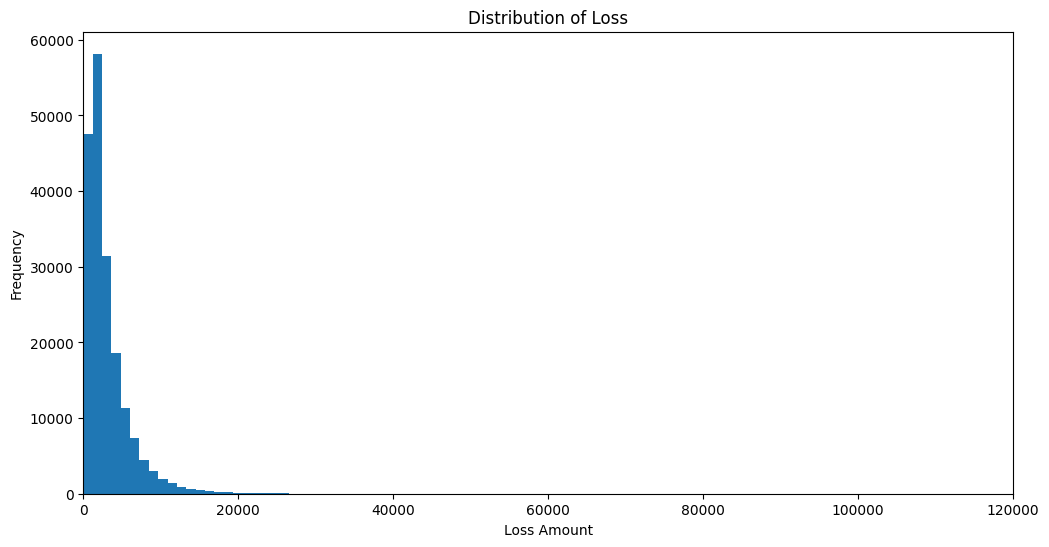

In [4]:
plt.figure(figsize=(12, 6))
plt.hist(data['loss'], bins=100)
plt.title('Distribution of Loss')
plt.xlabel('Loss Amount')
plt.ylabel('Frequency')
plt.xlim(0, 120000)
plt.show()

In [5]:
# Check skewness
print("skew value: ")
print(data['loss'].skew())

# Log transformation
data['log_loss'] = np.log1p(data['loss'])
data

skew value: 
3.7949583775378604


,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss,log_loss
0,1,A,B,A,B,A,A,A,A,B,...,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18,7.702637
1,2,A,B,A,A,A,A,A,A,B,...,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60,7.158203
2,5,A,B,A,A,B,A,A,A,B,...,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09,8.008396
3,10,B,B,A,B,A,A,A,A,B,...,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85,6.846784
4,11,A,B,A,B,A,A,A,A,B,...,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85,7.924742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188313,587620,A,B,A,A,A,A,A,A,B,...,0.289949,0.24564,0.30859,0.32935,0.223038,0.220003,0.333292,0.208216,1198.62,7.089760
188314,587624,A,A,A,A,A,B,A,A,A,...,0.382000,0.63475,0.40455,0.47779,0.307628,0.301921,0.318646,0.305872,1108.34,7.011521
188315,587630,A,B,A,A,A,A,A,B,B,...,0.370534,0.24564,0.45808,0.47779,0.445614,0.443374,0.339244,0.503888,5762.64,8.659324
188316,587632,A,B,A,A,A,A,A,A,B,...,0.562866,0.34987,0.44767,0.53881,0.863052,0.852865,0.654753,0.721707,1562.87,7.354919


In [6]:
# Determine which categorical values cannot be converted to boolean data
categorical = [x for x in data.columns if set(pd.unique(data[x])) != {'A', 'B'} and 'cat' in x]
categorical

['cat73',
 'cat74',
 'cat75',
 'cat76',
 'cat77',
 'cat78',
 'cat79',
 'cat80',
 'cat81',
 'cat82',
 'cat83',
 'cat84',
 'cat85',
 'cat86',
 'cat87',
 'cat88',
 'cat89',
 'cat90',
 'cat91',
 'cat92',
 'cat93',
 'cat94',
 'cat95',
 'cat96',
 'cat97',
 'cat98',
 'cat99',
 'cat100',
 'cat101',
 'cat102',
 'cat103',
 'cat104',
 'cat105',
 'cat106',
 'cat107',
 'cat108',
 'cat109',
 'cat110',
 'cat111',
 'cat112',
 'cat113',
 'cat114',
 'cat115',
 'cat116']

In [7]:
for col in [
    'cat73', 'cat74', 'cat75', 'cat76', 'cat77', 'cat78', 'cat79',
    'cat80', 'cat81', 'cat82', 'cat83', 'cat84', 'cat85', 'cat86',
    'cat87', 'cat88', 'cat89', 'cat90', 'cat91', 'cat92', 'cat93',
    'cat94', 'cat95', 'cat96', 'cat97', 'cat98', 'cat99', 'cat100',
    'cat101', 'cat102', 'cat103', 'cat104', 'cat105', 'cat106',
    'cat107', 'cat108', 'cat109', 'cat110', 'cat111', 'cat112',
    'cat113', 'cat114', 'cat115', 'cat116'
]:
    print(f"Unique values in {col}: {data[col].unique()}")


Unique values in cat73: ['A' 'B' 'C']
Unique values in cat74: ['A' 'B' 'C']
Unique values in cat75: ['B' 'A' 'C']
Unique values in cat76: ['A' 'C' 'B']
Unique values in cat77: ['D' 'C' 'B' 'A']
Unique values in cat78: ['B' 'A' 'C' 'D']
Unique values in cat79: ['B' 'D' 'A' 'C']
Unique values in cat80: ['D' 'B' 'A' 'C']
Unique values in cat81: ['D' 'B' 'A' 'C']
Unique values in cat82: ['B' 'A' 'D' 'C']
Unique values in cat83: ['D' 'B' 'A' 'C']
Unique values in cat84: ['C' 'A' 'D' 'B']
Unique values in cat85: ['B' 'A' 'C' 'D']
Unique values in cat86: ['D' 'B' 'C' 'A']
Unique values in cat87: ['B' 'C' 'D' 'A']
Unique values in cat88: ['A' 'D' 'E' 'B']
Unique values in cat89: ['A' 'B' 'C' 'E' 'D' 'H' 'I' 'G']
Unique values in cat90: ['A' 'B' 'C' 'D' 'F' 'E' 'G']
Unique values in cat91: ['A' 'B' 'G' 'C' 'D' 'E' 'F' 'H']
Unique values in cat92: ['A' 'H' 'B' 'C' 'D' 'I' 'F']
Unique values in cat93: ['D' 'C' 'A' 'B' 'E']
Unique values in cat94: ['B' 'D' 'C' 'A' 'F' 'E' 'G']
Unique values in cat

In [8]:
# One-hot encoding function
def process_cat(data, cat_features):
    for cat in cat_features:
        # Check if the column exists in the DataFrame before processing
        if cat in data.columns:  # This line added for check
            # One-hot encode the categorical feature
            data_cat = pd.get_dummies(data[cat], prefix=cat)

            # Join the new one-hot encoded columns with the original data
            data = data.join(data_cat)

            # Drop the original categorical columns
            data.drop(columns=cat, inplace=True)
        else:
            print(f"Column '{cat}' not found in DataFrame, skipping.") # Print if column not found

    return data

data = process_cat(data, categorical)

In [9]:
# Convert other categorical data into boolean data
for i in range(1, 73):
    data['cat' + str(i)] = data['cat' + str(i)].replace({'A': True, 'B': False})

data

<ipython-input-9-0eb525294640>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['cat' + str(i)] = data['cat' + str(i)].replace({'A': True, 'B': False})


,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cat116_P,cat116_Q,cat116_R,cat116_S,cat116_T,cat116_U,cat116_V,cat116_W,cat116_X,cat116_Y
0,1,True,False,True,False,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
1,2,True,False,True,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
2,5,True,False,True,True,False,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
3,10,False,False,True,False,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
4,11,True,False,True,False,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188313,587620,True,False,True,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
188314,587624,True,True,True,True,True,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False
188315,587630,True,False,True,True,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
188316,587632,True,False,True,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False


In [10]:
# Remove 'id'
X = data.drop(columns=['id', 'loss'])
y = data['loss']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Output the shapes of the training and test sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (150654, 1082) (150654,)
Test set shape: (37664, 1082) (37664,)


In [13]:
# Check for non-numeric columns
categorical_columns = data.select_dtypes(include=['object', 'category']).columns

# Display remaining categorical columns
print("Remaining categorical columns:", categorical_columns)

# check unique values in each categorical column
for col in categorical_columns:
    unique_values = data[col].unique()
    print(f"Unique values in {col}: {unique_values}")


Remaining categorical columns: Index([], dtype='object')


In [14]:
# Prepare data for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [15]:
# Set the parameters
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'random_state': 42
}


In [16]:
# Train the XGBoost
model = xgb.train(
    params,
    dtrain,
    num_boost_round=20000,  # Large number of trees
    evals=[(dtest, 'test')],
    early_stopping_rounds=50,
    verbose_eval=True
)

[0]	test-rmse:2582.15239
[1]	test-rmse:2335.67870
[2]	test-rmse:2114.34936
[3]	test-rmse:1916.61280
[4]	test-rmse:1739.20030
[5]	test-rmse:1580.63002
[6]	test-rmse:1438.60858
[7]	test-rmse:1311.98772
[8]	test-rmse:1198.10355
[9]	test-rmse:1097.02969
[10]	test-rmse:1008.44400
[11]	test-rmse:929.50268
[12]	test-rmse:859.79825
[13]	test-rmse:799.99369
[14]	test-rmse:748.17651
[15]	test-rmse:703.35367
[16]	test-rmse:662.35373
[17]	test-rmse:629.21026
[18]	test-rmse:600.34142
[19]	test-rmse:573.97567
[20]	test-rmse:553.44906
[21]	test-rmse:535.78691
[22]	test-rmse:520.12215
[23]	test-rmse:505.96697
[24]	test-rmse:495.16204
[25]	test-rmse:486.12438
[26]	test-rmse:478.50272
[27]	test-rmse:472.74706
[28]	test-rmse:466.51880
[29]	test-rmse:462.48532
[30]	test-rmse:457.28981
[31]	test-rmse:454.41368
[32]	test-rmse:452.12793
[33]	test-rmse:450.02165
[34]	test-rmse:446.81755
[35]	test-rmse:445.59973
[36]	test-rmse:443.81152
[37]	test-rmse:441.36158
[38]	test-rmse:440.91153
[39]	test-rmse:442.00550

In [17]:
# Predict on the test set
y_pred = model.predict(dtest)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Test RMSE: {rmse:.4f}")


Test RMSE: 426.2530


In [18]:
# Perform cross-validation
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=20000,
    nfold=5,
    early_stopping_rounds=50,
    metrics="rmse",
    seed=42
)


In [19]:
print(f"Cross-Validation RMSE: {cv_results['test-rmse-mean'].min():.4f}")

Cross-Validation RMSE: 443.6521


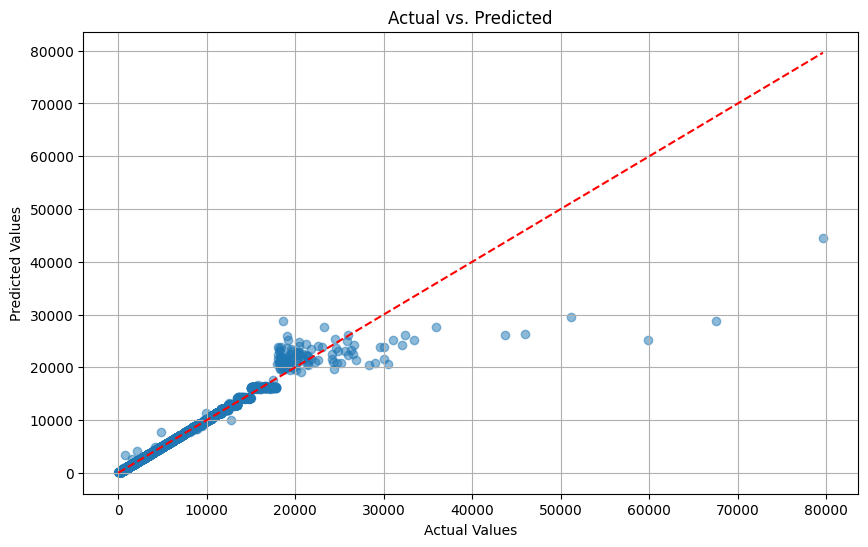

In [20]:
# Visualizing Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Diagonal line
plt.title('Actual vs. Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

In [28]:
# Randomized Search for hyperparameter tuning
param_distributions = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

In [29]:
random_search = RandomizedSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror'),
                                   param_distributions = param_distributions,
                                   n_iter=10000,
                                   scoring='neg_root_mean_squared_error',
                                   cv=3,
                                   verbose=1,
                                   n_jobs=-1,
                                   random_state=42)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200, 500],
                                        'subsample': [0.8, 1.0]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [30]:
print("Best Parameters:", random_search.best_params_)
best_model = random_search.best_estimator_

Best Parameters: {'subsample': 1.0, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01}


In [32]:
# Fit the best model on the training data
best_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_model.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test RMSE: {test_rmse:.4f}")


Test RMSE: 465.0580
